<a href="https://colab.research.google.com/github/DavMLPath/PhD-Theses/blob/main/Banking_Stability_Modeling_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from statistics import mean
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta



# **Loading data from drive, doing feature selection/transformation**

In [2]:
#importing libs for the model
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:

x=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Factors')


x.index=x['Date']
x.drop(columns=['Date'], inplace=True)
x['Mortgage loans']=np.log(x['Mortgage loans'])

In [4]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves', 'Medium term government bond yield',
       'Government bond yield (<365 days)',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI',
       'CPI-Consumer goods (including alcoholic beverages and tobacco)',
       'CPI-Non-consumer goods', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Tier 1 capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on assets',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
    

##**List of factors with growth rate**

In [5]:

#ROA+(equity/assets))/sd(ROA)

to_change=[
'Industry Loans'
,'Demand deposits in AMD (million AMD)'
,'Time deposits in AMD (million AMD)'
,'Foreign currency deposits (million AMD)'
,'Inv. comp. Sales and purchase transactions (million AMD)'
,'Construction loans'
,'Agriculture loans'
#,'Accumulated profit (million AMD)'
,'Total capital (million AMD)'
,'Consumer loans loans'
#,'Repo agreements (million AMD)'
,'Mortgage loans'
,'Trade loans'
,'Total liabilities (million AMD)'
,'High liquidity assets ratio to demand liabilities'
,'Russian Ruble/AMD'
,'Euro/AMD'
,'US Dollar/AMD'
,'Normative capital ratio to risk-weighted assets'
,'High liquidity assets ratio to total assets'
,'CPI'
]

for i in to_change:
  x[i]=x[i].pct_change()


##Definin factors to remove/combine

In [6]:
x['Dolarisation_avg']=(x['D1']+x['D2']+x['D3']+x['D5']+x['D4'])/4
x['Gov. bond yealds']=(x['Medium term government bond yield']+x['Government bond yield (<365 days)'])/2
x['fc-loans']=x["Industry Loans (fc)"]+x["Agriculture loans (fc)"]+x["Construction loans (fc)"]+x["Trade loans (fc)"]+x["Service sector loans (fc)"]+x["Consumer loans loans (fc)"]+x["Others loans (fc)"]
x.drop(columns=['Repo agreements (million AMD)','Accumulated profit (million AMD)','Total assets (million AMD)','Return on assets','Industry Loans (fc)', 'Agriculture loans (fc)', 'Construction loans (fc)', 'Trade loans (fc)', 'Service sector loans (fc)', 'Consumer loans loans (fc)', 'Others loans (fc)', 'D1', 'D2', 'D3', 'D4', 'D5','Medium term government bond yield','Government bond yield (<365 days)'], inplace=True)
x.drop(columns=['British Pound Sterling/AMD', 'Iranian Rial/AMD','Tier 1 capital ratio to risk-weighted assets','CPI-Consumer goods (including alcoholic beverages and tobacco)','CPI-Non-consumer goods','Swiss Franc/AMD', 'Georgian Lari/AMD'], inplace=True)

x['Dolarisation_avg']=x['Dolarisation_avg'].pct_change()
x.drop('2012-12-01', inplace=True)


In [7]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [8]:
y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')

# # x.columns=x.iloc[0,:]

y.index=y['Date']
y.drop(columns=['Date'], inplace=True)
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


##Droping some factors

In [9]:
x.drop(
[
'Foreign currency deposits (million AMD)'
,'Outflow (non-trade)'
,'fc-loans'
,'High liquidity assets ratio to demand liabilities'


,'Transport and communications loans (fc)',
'Transport and communications loans'

],axis=1, inplace =True)

In [10]:
x_back=x.copy(deep=True)

In [11]:
y_back=y.copy(deep=True)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
decomposed = seasonal_decompose(y, period=12, model='additive')
# data['seasonal_component'] = decomposed.seasonal
# data['trend_component'] = decomposed.trend
# data['residual_component'] = decomposed.resid  # The stationary part
y_seasonal = decomposed.seasonal
y_trend = decomposed.trend
y_residual = decomposed.resid

##Stationarity adjustments


In [13]:
#function for checking stationarity and returinig stationarized series
def check_stationarity(series):
  for i in range(0, 50):
      if i==0:
        dep_var = series
      else:
        dep_var= series - series.shift(i).fillna(0)
      result = adfuller(dep_var)
      adf_statistic = result[0]
      p_value = result[1]
      if float(("%.17f" % p_value).rstrip('0').rstrip('.'))<=0.05:
        break
  return i,("%.17f" % p_value).rstrip('0').rstrip('.'), dep_var
#      print("p-value:", ("%.17f" % p_value).rstrip('0').rstrip('.'))

In [14]:
#choosing stationarity parameter for the dependent variable
a=check_stationarity(y['Z-score'])
y=a[2]
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,0.429852
2013-03-01,-0.614530
2013-04-01,-1.349483
2013-05-01,2.562559
...,...
2024-08-01,0.994868
2024-09-01,0.930966
2024-10-01,-2.251795


In [15]:
#x.info()

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
#creating dictionary with stationarised variables
dict_normalized=pd.DataFrame()
stationarity=[]
features=[]
levels=[]
for i in x:
  if i not in ['Date', 'Բանկային տոկոս']:
    x[i].fillna(0, inplace = True)
    dict_normalized[i]=check_stationarity(x[i])[2]
    #print(check_stationarity(x[i])[0]   )
    stationarity.append([i, check_stationarity(x[i])[0]])
    features.append(i)
    levels.append(check_stationarity(x[i])[0])
# dict_normalized

In [18]:
print(len(features))
print(len(levels))
# pd.DataFrame({"name":features, "diff_level":levels})

38
38


In [19]:
type(dict_normalized.std().values)

numpy.ndarray

In [20]:
denormdf=pd.DataFrame({"name":features, "diff_level":levels})
denormdf.sort_values(by='diff_level', ascending=False)

,name,diff_level
35,bitcoin_price,5
34,Mortgage loans (fc),4
25,Foreign debt,3
20,Cash in circulation (million AMD),2
37,Gov. bond yealds,2
0,Inflow (trade),1
33,Others loans,1
5,Government’s net domestic assets (million AMD),1
4,Foreign Exchange Reserves,1
2,Outflow (trade),1


In [23]:
#variables, that are not stationary after 3-rd lag, we will exclude from model
s_list=pd.DataFrame(stationarity, columns=["factor", "level"])
valid_factors=s_list['factor'][s_list['level'].astype(float)<=5]
invalid_factors=s_list['factor'][s_list['level'].astype(float)>5]
# valid_factors

In [24]:
s_list[s_list['factor'].isin(invalid_factors)]

,factor,level


In [25]:
x=dict_normalized
x=x[valid_factors]

In [26]:
y=pd.DataFrame({'Z-score':y})
#y

In [27]:
denormdf=denormdf[denormdf['name'].isin(x.columns.values)]

In [28]:
denormdf.sort_values(by='diff_level', ascending=False)

,name,diff_level
35,bitcoin_price,5
34,Mortgage loans (fc),4
25,Foreign debt,3
20,Cash in circulation (million AMD),2
37,Gov. bond yealds,2
0,Inflow (trade),1
33,Others loans,1
5,Government’s net domestic assets (million AMD),1
4,Foreign Exchange Reserves,1
2,Outflow (trade),1


# **checking multicolinearity**


In [29]:
Highly_Correlated_column_name = {}
corr = x.corr().to_numpy()
column_names = x.columns
row_no = 0
for r in corr:
    col_no = 0
    for c in r:
        if (c>0.9 and c<1) or (c<-0.9 and c>-1):
            if column_names[row_no] in Highly_Correlated_column_name:
              if column_names[col_no] not in Highly_Correlated_column_name[column_names[row_no]]:
                Highly_Correlated_column_name[column_names[row_no]].append(column_names[col_no])
            else:
              Highly_Correlated_column_name[column_names[row_no]] = [column_names[col_no]]
            print(f"'{column_names[row_no]}', '{column_names[col_no]}', {c}")
        col_no+=1
    row_no += 1

In [30]:
# data=pd.concat([x,y], axis=1)

##filtering with vif after differencing

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Add constant for intercept
from statsmodels.tools import add_constant
X_v_const = add_constant(x)



# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_v_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_v_const.values, i) for i in range(X_v_const.shape[1])]

#print(vif_data)
to_remove_vif=vif_data[vif_data['VIF']>5]
to_keep_vif=vif_data[vif_data['VIF']<5]
#x=x[to_keep_vif['Feature'].values]

In [32]:
to_remove_vif

,Feature,VIF
0,const,41869.052445
26,Foreign debt,5.258728
38,Gov. bond yealds,5.246524


##Creating scaled factors

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(x)
x_s=pd.DataFrame(scaled, columns=x.columns.values)

##**Filtering factors with ridge, lasso**

In [34]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LassoCV
# Create and fit the Group Lasso model
# Define a range of alpha values in log space
alphas = [0.1]#np.logspace(-4, 1, 50)  # From 0.0001 to 10

tscv = TimeSeriesSplit(n_splits=5)  # 5 sequential splits

# Fit LassoCV with time-aware CV
lasso_cv = LassoCV(alphas=alphas, cv=tscv, random_state=43).fit(x_s, y)

# Best alpha value
print("Best alpha:", lasso_cv.alpha_)
lasso_coefs = lasso_cv.coef_

# Best alpha value
print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.1
Best alpha: 0.1


In [35]:
from decimal import Decimal

In [36]:
lasso_eval=pd.DataFrame({"var_name": x.columns.values, "lasso_coef":lasso_coefs})

#CV=4
lasso_remove=lasso_eval['var_name'][lasso_eval['lasso_coef']==0].values
lasso_remove
lasso_eval['lasso_coef']=lasso_eval['lasso_coef'].apply(lambda i: Decimal(i) )

In [37]:
print(len(x.columns.values))
print(len(lasso_coefs))
print(len(lasso_remove))

38
38
23


In [38]:
selected_features = x.columns[np.abs(lasso_cv.coef_) > 0]
print("Selected features:", list(selected_features))
lasso_significant=lasso_eval[lasso_eval['lasso_coef']!=0]

Selected features: ['Inflow (non-trade)', 'Foreign Exchange Reserves', 'Government’s net domestic assets (million AMD)', 'Banks’ net domestic assets (million AMD)', 'CPI-Services', 'Inv. comp. Sales and purchase transactions (million AMD)', 'Return on capital', 'High liquidity assets ratio to total assets', 'US Dollar/AMD', 'Russian Ruble/AMD', 'Demand deposits in AMD (million AMD)', 'Total capital (million AMD)', 'Industry Loans', 'Mortgage loans', 'Dolarisation_avg']


In [39]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define alpha values for Ridge regularization
alphas = np.logspace(-4, 4, 50)  # 0.0001 to 10,000

# Standardize features
scaler = StandardScaler()

# Define TimeSeriesSplit for time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

# Store results
alpha_scores = {}

# Loop over different alphas to find the best one
for alpha in alphas:
    scores = []

    # TimeSeries CV evaluation
    for train_idx, test_idx in tscv.split(x_s):
        X_train, X_test = x_s.iloc[train_idx], x_s.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train Ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)

        # Predict on validation set
        y_pred = ridge.predict(X_test)

        # Evaluate performance
        score = r2_score(y_test, y_pred)
        scores.append(score)

    # Store the average R² score for this alpha
    alpha_scores[alpha] = np.mean(scores)

# Select the best alpha
best_alpha = max(alpha_scores, key=alpha_scores.get)
print("Best Alpha:", best_alpha)

# Train final Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(x_s, y)

# Evaluate on the full dataset (or separate test set)
y_pred = ridge_best.predict(x_s)

# Compute evaluation metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

print("Final Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Inspect coefficients
ridge_coef = ridge_best.coef_
ridge_df = pd.DataFrame({'factors': x_s.columns.values, 'score': ridge_coef})
print(ridge_df)

Best Alpha: 24.420530945486497
Final Model Evaluation:
R² Score: 0.7135
MSE: 0.7873
RMSE: 0.8873
MAE: 0.6885
                                              factors     score
0                                      Inflow (trade)  0.022779
1                                  Inflow (non-trade)  0.375140
2                                     Outflow (trade) -0.082317
3                         Reserve position in the IMF  0.022131
4                           Foreign Exchange Reserves  0.635563
5      Government’s net domestic assets (million AMD)  0.132552
6            Banks’ net domestic assets (million AMD)  0.431798
7                      Net other assets (million AMD)  0.095773
8                                                 CPI -0.066382
9                                        CPI-Services -0.129255
10                            Economic activity index -0.038533
11  Inv. comp. Sales and purchase transactions (mi...  0.065688
12         Inv. comp. Repo transactions (million AMD) -0.02

In [40]:
ridge_significant=ridge_df[abs(ridge_df['score'])>0.05]
ridge_insignificant=ridge_df[abs(ridge_df['score'])<=0.05]
ridge_df.sort_values(by='score')
print(len(ridge_significant))
ridge_insignificant

23


,factors,score
0,Inflow (trade),0.022779
3,Reserve position in the IMF,0.022131
10,Economic activity index,-0.038533
12,Inv. comp. Repo transactions (million AMD),-0.020089
18,Euro/AMD,-0.010820
20,Cash in circulation (million AMD),0.038973
22,Time deposits in AMD (million AMD),0.022959
25,Foreign debt,-0.012547
27,Agriculture loans,-0.003198
29,Trade loans,0.012577


In [41]:
x.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Date', length=144, freq=None)

In [42]:
# vars=pd.concat([y,x], axis=1)
# vars
y.index=x.index
z=pd.concat([x,y], axis=1)
# z=z.astype(float)

In [43]:
l1=[i for i in lasso_remove]
l2=[i for i in ridge_insignificant['factors'].values]

combined_list =  l2+l1

to_remove = list(set(combined_list))

In [44]:
factors_cleaned=z[[i for i in z.columns.values if i not in to_remove]]
factors_cleaned=factors_cleaned.astype('float')
len(factors_cleaned.columns.values)

16

##Scaling factors

In [45]:
factors_cleaned.columns.values

array(['Inflow (non-trade)', 'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)', 'CPI-Services',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'US Dollar/AMD', 'Russian Ruble/AMD',
       'Demand deposits in AMD (million AMD)',
       'Total capital (million AMD)', 'Industry Loans', 'Mortgage loans',
       'Dolarisation_avg', 'Z-score'], dtype=object)

In [46]:
factors_cleaned.columns.values
y_f=factors_cleaned['Z-score']
x_f=factors_cleaned.drop(['Z-score'], axis=1)#,'Foreign currency deposits (million AMD)','Outflow (non-trade)'], axis=1)#

In [47]:
x_f.columns.values

array(['Inflow (non-trade)', 'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)', 'CPI-Services',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'US Dollar/AMD', 'Russian Ruble/AMD',
       'Demand deposits in AMD (million AMD)',
       'Total capital (million AMD)', 'Industry Loans', 'Mortgage loans',
       'Dolarisation_avg'], dtype=object)

##Defining time factor

In [48]:
def add_time(df):

#the best combos are seasonality and quarter

  a = pd.to_datetime(df.index)
# Extracting time-based features
#x['year'] = x['timestamp'].dt.year
  #
  #df['month'] = a.month
  df['quarter'] = a.quarter


  # df['year'] = a.year
# Cyclical transformation for 'month'
  #df['month_1_sin'] = np.sin(2 * np.pi * a.month / 12)
  #df['month_1_cos'] = np.cos(2 * np.pi * a.month / 12 / 12)
  #df['month_2_sin'] = np.sin(2 *2* np.pi * a.month  / 12)
 # df['month_2_cos'] = np.cos(2 *2* np.pi * a.month / 12)
  df['seasonal']=y_seasonal
  # df['trend']=y_trend
  # df['residual']=y_residual
# Display the DataFrame with new features


In [49]:
x_f.isnull().sum()

,0
Inflow (non-trade),0
Foreign Exchange Reserves,0
Government’s net domestic assets (million AMD),0
Banks’ net domestic assets (million AMD),0
CPI-Services,0
Inv. comp. Sales and purchase transactions (million AMD),0
Return on capital,0
High liquidity assets ratio to total assets,0
US Dollar/AMD,0
Russian Ruble/AMD,0


#**Evaluating LSTM Model**




In [50]:
# a=pd.DataFrame(X_train.std())
# a.to_csv('/content/drive/My Drive/Dissertation/stevs.csv')

##**LSTM for filtered**

In [51]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from itertools import product

# Set random seed for reproducibility

import os
import random
import numpy as np
import tensorflow as tf

os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_f, y, test_size=0.1, random_state=26, shuffle=False)

import numpy as np
X_train_mean = X_train.mean(axis=0)  # Shape: (n_features,)
X_train_std = X_train.std(axis=0, ddof=1)  # Shape: (n_features,)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std


Y_train_mean=np.mean(y_train)
Y_train_std=np.std(Y_train)


Y_train=(Y_train-Y_train_mean)/Y_train_std
Y_test=(Y_test-Y_train_mean)/Y_train_std


add_time(X_train)
add_time(X_test)


X_data = X_train.values  # shape: (n_samples, n_features)
y_data = Y_train.values  # shape: (n_samples,) or (n_samples, target_dim)

In [53]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense

import numpy as np
import itertools

# Function to create sequences
def create_sequences(data, target, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)


In [54]:
Y_test

,Z-score
Date,
2023-10-01,-0.583378
2023-11-01,-0.029524
2023-12-01,0.345298
2024-01-01,-1.454269
2024-02-01,1.314489
2024-03-01,-0.156367
2024-04-01,-0.776510
2024-05-01,0.449603
2024-06-01,0.380915


##Applying Grid search for identifying best hyperparameters

In [55]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense

import numpy as np
import itertools

# Function to create sequences
def create_sequences(data, target, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# # Define your hyperparameter grid
# time_steps_list = [3,5, 6,7,8]
# units_list = [10,20, 25,30,35,40]
# batch_sizes = [8, 16]
# learning_rates = [0.001, 0.01]


# best_mse = float('inf')
# best_params = None
# results = []

# for time_steps, units, batch_size, lr in itertools.product(time_steps_list, units_list, batch_sizes, learning_rates):

#     # Recreate sequences
#     X_seq, y_seq = create_sequences(X_data, y_data, time_steps=time_steps)
#     X_val_split = int(len(X_seq) * 0.875)

#     X_train_seq, X_val_seq = X_seq[:X_val_split], X_seq[X_val_split:]
#     y_train_seq, y_val_seq = y_seq[:X_val_split], y_seq[X_val_split:]

#     # Build and compile model
#     model = Sequential()
#     model.add(LSTM(units, input_shape=(X_seq.shape[1], X_seq.shape[2]), dropout=0.2,
#                    recurrent_dropout=0.2
#                    ))
#     model.add(Dense(1))
#     model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

#     early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#     # Train
#     history = model.fit(X_train_seq, y_train_seq,
#                         validation_data=(X_val_seq, y_val_seq),
#                         epochs=50,
#                         batch_size=batch_size,
#                         callbacks=[early_stop],
#                         verbose=0,
#                         shuffle=False)

#     # Evaluate
#     val_mse = model.evaluate(X_val_seq, y_val_seq, verbose=0)
#     results.append((val_mse, time_steps, units, batch_size, lr))

#     if val_mse < best_mse:
#         best_mse = val_mse
#         best_params = (time_steps, units, batch_size, lr)

# print("\nBest MSE:", best_mse)
# print("Best Params: time_steps={}, units={}, batch_size={}, lr={}".format(*best_params))


In [56]:
#setting up best params
#we choose learning rate as 0,01 as it gives the best results

##Evaluating model based on  best params

In [57]:
best_params=(([3], 10 ,16, 0.01))

In [58]:
# Unpack best params
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


time_steps, units, batch_size, lr = best_params
for i in range(len(time_steps)):

  import os
  import random
  import numpy as np
  import tensorflow as tf

  os.environ['TF_DETERMINISTIC_OPS'] = '1'

  seed_value = 42
  random.seed(seed_value)
  np.random.seed(seed_value)
  tf.random.set_seed(seed_value)
# Recreate sequences using best time_steps
  X_seq, y_seq = create_sequences(X_data, y_data, time_steps=time_steps[i])
  X_val_split = int(len(X_seq) * 0.875)
  X_train_seq, X_val_seq = X_seq[:X_val_split], X_seq[X_val_split:]
  y_train_seq, y_val_seq = y_seq[:X_val_split], y_seq[X_val_split:]

  # Build and train the best model again
  best_model = Sequential()
  best_model.add(LSTM(units, input_shape=(X_seq.shape[1], X_seq.shape[2]), dropout=0.2, recurrent_dropout=0.2))
  best_model.add(Dense(1))
  best_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

  best_model.fit(X_train_seq, y_train_seq,
                 validation_data=(X_val_seq, y_val_seq),
                 epochs=50,
                 batch_size=batch_size,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                 verbose=0,
                 shuffle=False)

  # Now predict
  # predictions = best_model.predict(X_test_seq)



  X_test_seq, y_test_seq = create_sequences(X_test.values, Y_test.values, time_steps=best_params[0][i])

  print("Test Data Shape:", X_test_seq.shape)  # Should be (samples, timesteps, features)
  print('here is the result for window ',best_params[0][i])
  y_pred = best_model.predict(X_test_seq)
  y_test_flat = y_test_seq.flatten()
  y_pred_flat = y_pred.flatten()

  mae = mean_absolute_error(y_test_flat, y_pred_flat)
  mse = mean_squared_error(y_test_flat, y_pred_flat)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(y_test_flat, y_pred)

  final_r2 = r2_score(y_test_flat, y_pred_flat)

  print('Forecast Accuracy Metrics:')
  print(f"Final Model R² Score: {final_r2:.4f}")

  print(f'MAE: {mae}')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape}')

Test Data Shape: (12, 3, 17)
here is the result for window  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Forecast Accuracy Metrics:
Final Model R² Score: 0.6469
MAE: 0.47477493062891085
MSE: 0.3378168476733377
RMSE: 0.5812201370163784
MAPE: 0.7494635052185483


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Actual: [-1.45426913  1.31448862 -0.15636711 -0.77651038  0.44960298]
Predicted: [-1.3047863   0.7967191   0.29851198 -0.44982058  0.7003855 ]


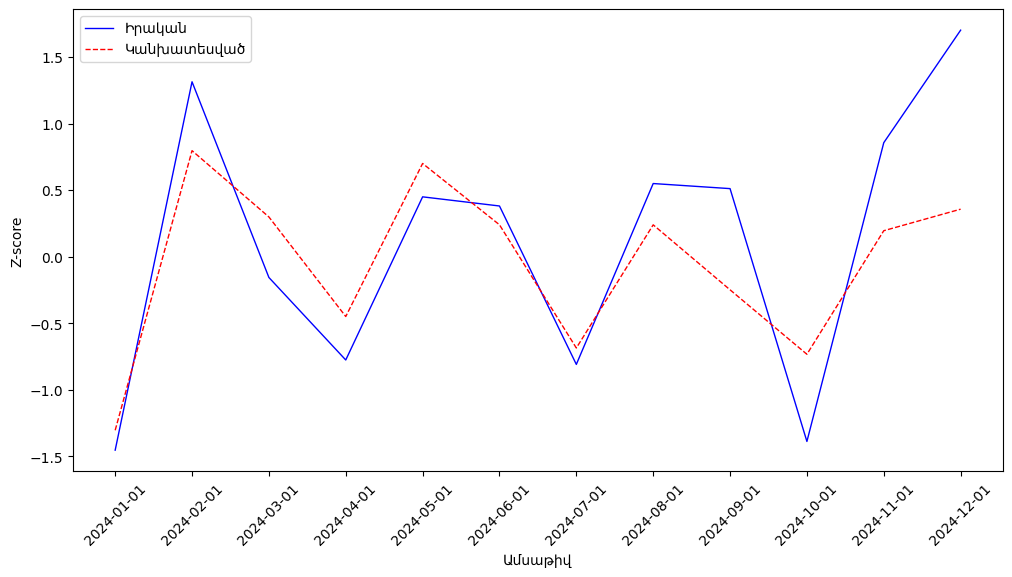

In [59]:
# Predict using the trained RNN model
y_pred = best_model.predict(X_test_seq)
# Print first few values for comparison
print("Actual:", y_test_seq[:5].flatten())
print("Predicted:", y_pred[:5].flatten())
y_test_flat = y_test_seq.flatten()
y_pred_flat = y_pred.flatten()
# Define the range for the x-axis
x_range = range(len(y_test_flat))
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_range, y_test_flat, label='Իրական', color='blue', linestyle='-', linewidth=1)
plt.plot(x_range, y_pred_flat, label='Կանխատեսված', color='red', linestyle='--', linewidth=1)
plt.xlabel('Ամսաթիվ')
plt.ylabel('Z-score')

plt.xticks(ticks=range(0,12),labels=Y_test[-12:].index.date, rotation=45)

plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error
import numpy as np
# Assuming y_test_seq and y_pred are your actual and predicted values respectively
# Flatten the arrays to ensure they are 1-dimensional
y_test_flat = y_test_seq.flatten()
y_pred_flat = y_pred.flatten()
# Calculate RMSE
rmse = np.sqrt(np.mean((y_test_flat - y_pred_flat) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 0.5812201370163784


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_flat, y_pred)

final_r2 = r2_score(y_test_flat, y_pred_flat)

print('Forecast Accuracy Metrics:')
print(f"Final Model R² Score: {final_r2:.4f}")

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Forecast Accuracy Metrics:
Final Model R² Score: 0.6469
MAE: 0.47477493062891085
MSE: 0.3378168476733377
RMSE: 0.5812201370163784
MAPE: 0.7494635052185483


In [62]:
"""
without time component, we do have Root Mean Square Error (RMSE): 2.2604366205832016
with adding month component, Root Mean Square Error (RMSE): 2.1726543300520182
with adding month sin, cos, Root Mean Square Error (RMSE): 2.1384817080191714
"""

'\nwithout time component, we do have Root Mean Square Error (RMSE): 2.2604366205832016\nwith adding month component, Root Mean Square Error (RMSE): 2.1726543300520182\nwith adding month sin, cos, Root Mean Square Error (RMSE): 2.1384817080191714\n'

# Feature importance

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
                                              Feature  Importance
0            Banks’ net domestic assets (million AMD)    0.653317
1      Government’s net domestic assets (million AMD)    0.103741
2                                            seasonal    0.078746
3                           Foreign Exchange Reserve

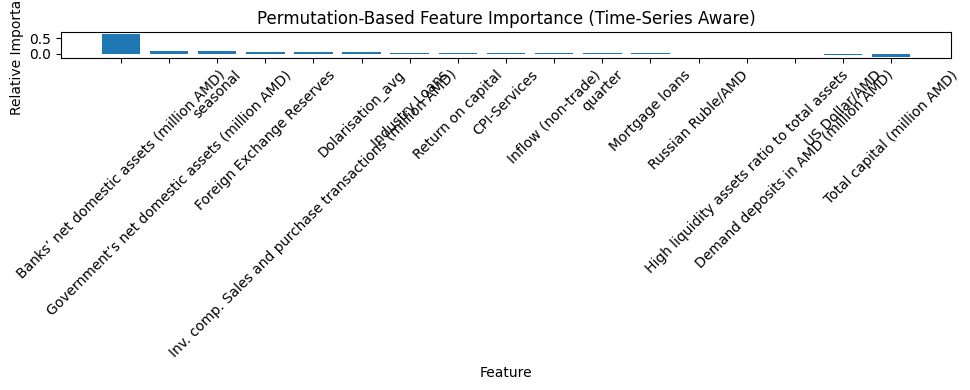

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume:
# X_test_seq: shape (n_sequences, sequence_length, n_features)
# y_test_seq: shape (n_sequences,)
# best_model: trained 1D CNN model
# X_test: DataFrame with feature names (optional)

# Get feature names
feature_names = list(X_test.columns.values) if isinstance(X_test, pd.DataFrame) else [f'feature_{i}' for i in range(X_test_seq.shape[2])]

# 1. Baseline prediction
baseline_preds = best_model.predict(X_test_seq)
baseline_mse = mean_squared_error(y_test_seq, baseline_preds)

importances = []

# 2. Loop over features
for feature_idx in range(X_test_seq.shape[2]):
    X_permuted = X_test_seq.copy()

    # 3. Shuffle across samples for each time step, preserving sequence structure
    for t in range(X_test_seq.shape[1]):  # loop through time steps
        temp = X_permuted[:, t, feature_idx].copy()
        np.random.shuffle(temp)
        X_permuted[:, t, feature_idx] = temp

    # 4. Predict with permuted feature
    permuted_preds = best_model.predict(X_permuted)
    permuted_mse = mean_squared_error(y_test_seq, permuted_preds)
    importances.append(permuted_mse - baseline_mse)

# 5. Normalize importances
importances = np.array(importances)
normalized_importances = importances / np.sum(importances)

# 6. Format output
importance_dict = dict(zip(feature_names, normalized_importances))
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# 7. Display results
print(importance_df)

# 8. Plot results
plt.figure(figsize=(10, 4))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title("Permutation-Based Feature Importance (Time-Series Aware)")
plt.xlabel("Feature")
plt.ylabel("Relative Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
# importance_df.to_csv('/content/drive/My Drive/Dissertation/importance_lstm.csv')